In [ ]:
!pip install python_speech_features

In [ ]:
!pip install sounddevice

In [ ]:
!pip install pyaudio

In [ ]:
pip install librosa scikit-learn python_speech_features sounddevice tqdm

In [ ]:
pip install sounddevice

In [ ]:
!pip install resampy

In [ ]:
!pip install --upgrade librosa

In [50]:
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from python_speech_features import mfcc
from tqdm import tqdm
#import sounddevice as sd

In [51]:
import librosa
import numpy as np

# Function to extract MFCC features
def extract_mfcc_features(audio, sr=16000, num_cepstral=13, frame_length=0.02, frame_stride=0.02,
                           num_filters=32, fft_length=320, preemphasis_coeff=0.98):
    # Apply pre-emphasis
    audio = np.append(audio[0], audio[1:] - preemphasis_coeff * audio[:-1])

    # Compute the short-time Fourier transform (STFT)
    hop_length = int(frame_stride * sr)
    n_fft = fft_length
    window = "hann"  # You can choose a different window function if needed
    stft_result = librosa.core.stft(audio, hop_length=hop_length, n_fft=n_fft, window=window)

    # Compute the mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(S=np.abs(stft_result)**2, sr=sr, n_mels=num_filters)

    # Logarithm of the mel spectrogram
    log_mel_energy = np.log(mel_spectrogram + 1e-9)

    # Extract MFCC features using DCT
    mfcc_features = librosa.feature.mfcc(S=log_mel_energy, n_mfcc=num_cepstral)

    # Apply mean and variance normalization across time
    mfcc_features = librosa.util.normalize(mfcc_features, norm=2, axis=0, fill=True)

    return mfcc_features

In [52]:
# # Function to load data and preprocess
# def preprocess_data(data_dir, test_size=0.2):
#     labels = []
#     features = []

#     for class_label in os.listdir(data_dir):
#         class_path = os.path.join(data_dir, class_label)
#         if os.path.isdir(class_path):  # Ensure it's a directory
#             for file_name in tqdm(os.listdir(class_path), desc=f"Processing {class_label}"):
#                 file_path = os.path.join(class_path, file_name)
#                 audio, _ = librosa.load(file_path, res_type='kaiser_fast', duration=2.0, offset=0.0)
#                 mfcc_features = extract_mfcc_features(audio)
#                 features.append(mfcc_features)
#                 labels.append(class_label)

#     features = np.array(features)
#     labels = np.array(labels)

#     # Split the data into training and testing sets
#     X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=test_size, random_state=42)

#     return (X_train, y_train), (X_test, y_test), labels

In [53]:
def preprocess_data(data_dir):
    data = []
    labels = []
    features = []

    for class_label in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_label)
        for file_name in tqdm(os.listdir(class_path), desc=f"Processing {class_label}"):
            file_path = os.path.join(class_path, file_name)
            audio, _ = librosa.load(file_path, sr = 16000)

            # Simply append the raw audio data to the dataset
            data.append({
                'audio': audio,
                'label': class_label
            })
            mfcc_features = extract_mfcc_features(audio)
            features.append(mfcc_features)
            labels.append(class_label)

    features = np.array(features)
    labels = np.array(labels)
    classes = set(labels)

     #Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

    return features ,classes ,(X_train, y_train), (X_test, y_test)
# Example usage
data_dir = "/content/drive/MyDrive/hackathon"

In [54]:
import keras
from keras.layers import Input, Reshape, Conv1D, MaxPooling1D, Dropout, Flatten, Dense
from keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder

def train_model(X_train, y_train, num_classes, X_test, y_test):
    encoder = LabelEncoder()
    encoded_labels_train = encoder.fit_transform(y_train)
    encoded_labels_test = encoder.transform(y_test)  # Use transform for test data

    model = keras.Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        Reshape((13, -1)),
        Conv1D(8, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Dropout(0.25),
        Conv1D(16, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Dropout(0.25),
        Flatten(),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    model.fit(X_train, encoded_labels_train, epochs=100, batch_size=32, validation_data=(X_test, encoded_labels_test))

    return model, encoder


# Assuming you have features, classes, (X_train, y_train), (X_test, y_test) from preprocess_data
features, classes, (X_train, y_train), (X_test, y_test) = preprocess_data(data_dir)
num_classes = len(classes)

# Train the model
trained_model, label_encoder = train_model(X_train, y_train, num_classes, X_test, y_test)

Processing door_stop: 100%|██████████| 2823/2823 [00:14<00:00, 198.58it/s]


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_4 (Reshape)         (None, 13, 51)            0         
                                                                 
 conv1d_8 (Conv1D)           (None, 11, 8)             1232      
                                                                 
 max_pooling1d_8 (MaxPoolin  (None, 5, 8)              0         
 g1D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 5, 8)              0         
                                                                 
 conv1d_9 (Conv1D)           (None, 3, 16)             400       
                                                                 
 max_pooling1d_9 (MaxPoolin  (None, 1, 16)             0         
 g1D)                                                 

80/80 [==============================] - 0s 5ms/step
Accuracy: 91.98%
Precision: 92.05%
Recall: 91.98%
F1 Score: 91.94%


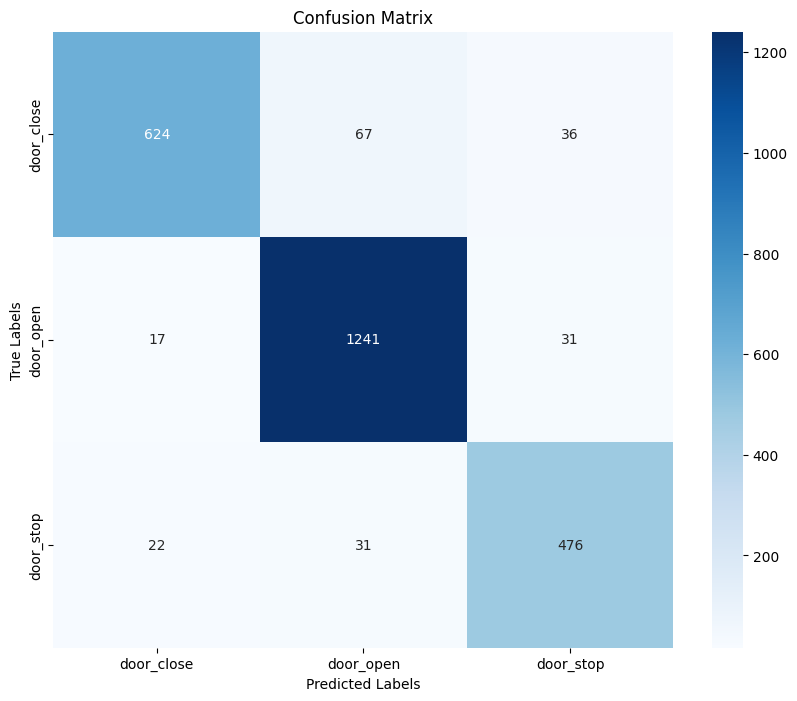

In [61]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Function to calculate and print multiple evaluation metrics
def evaluate_model(model, X_test, y_test, label_encoder):
    # Predictions on test set
    y_pred = model.predict(X_test)

    # Convert predictions to class labels
    y_pred_labels = label_encoder.inverse_transform(np.argmax(y_pred, axis=1))

    # Calculate and print accuracy
    accuracy = accuracy_score(y_test, y_pred_labels)
    print(f'Accuracy: {accuracy * 100:.2f}%')

    # Calculate and print precision, recall, and F1 score
    precision = precision_score(y_test, y_pred_labels, average='weighted')
    recall = recall_score(y_test, y_pred_labels, average='weighted')
    f1 = f1_score(y_test, y_pred_labels, average='weighted')

    print(f'Precision: {precision * 100:.2f}%')
    print(f'Recall: {recall * 100:.2f}%')
    print(f'F1 Score: {f1 * 100:.2f}%')

    # Generate and plot confusion matrix
    cm = confusion_matrix(y_test, y_pred_labels, labels=label_encoder.classes_)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Assuming you have the trained_model, X_test, y_test, and label_encoder
evaluate_model(trained_model, X_test, y_test, label_encoder)


In [55]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Predictions on test set
y_pred_probs = trained_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Convert predictions back to original labels if needed
y_pred_original = label_encoder.inverse_transform(y_pred)


# Convert predictions back to original labels if needed
y_pred_original = label_encoder.inverse_transform(y_pred)

# Accuracy
accuracy = accuracy_score(encoded_labels_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Classification Report
class_report = classification_report(encoded_labels_test, y_pred)
print('Classification Report:\n', class_report)

# Confusion Matrix
conf_matrix = confusion_matrix(encoded_labels_test, y_pred)
print('Confusion Matrix:\n', conf_matrix)


80/80 [==============================] - 0s 1ms/step


NameError: name 'encoded_labels_test' is not defined

# **Inferencing**


In [ ]:
# Real-time inference
def real_time_inference(model, encoder):
    duration = 1  # seconds
    sample_rate = 16000

    print("Listening for real-time inference...")

    p = pyaudio.PyAudio()
    stream = p.open(format=pyaudio.paInt16,
                    channels=1,
                    rate=sample_rate,
                    input=True,
                    frames_per_buffer=int(sample_rate * duration))

    while True:
        # Record audio from the microphone
        audio_input = np.frombuffer(stream.read(int(sample_rate * duration), exception_on_overflow=False), dtype=np.int16)

        # Extract MFCC features from the audio input
        mfcc_features = extract_features(audio_input)

        # Perform real-time prediction
        prediction = model.predict([mfcc_features])

        # Inverse transform to get the predicted class label
        class_label = encoder.inverse_transform(prediction)[0]

        # Print the predicted class label
        print(f"Predicted class: {class_label}")

    stream.stop_stream()
    stream.close()
    p.terminate()

# Define your data directory
data_directory = "/Users/snigdhaasthana/Desktop/hackathon"

# Preprocess data
features, labels = preprocess_data(data_directory)

# Train the model
trained_model, label_encoder = train_model(features, labels)

# Real-time inference
real_time_inference(trained_model, label_encoder)